In [1]:
import gym
import numpy as np
from gym.envs.registration import register
import matplotlib.pyplot as plt
import operator

In [2]:
register(
    id='D4x4-FrozenLake-v0',
    entry_point='gym.envs.toy_text.frozen_lake:FrozenLakeEnv',
    kwargs={'map_name': '4x4',
            'is_slippery': False})

env = gym.make('D4x4-FrozenLake-v0')

In [3]:
def get_optimal_action(action_space, V, gamma = 0.9):
    
    # One step optimal action and corrresponding value
    
    val = {}
    
    for action in action_space.keys():
        val[action] = 0
        for prob, next_state, reward, _ in action_space[action]:
            val[action] += prob*(reward + gamma*V[next_state])
            
    return max(val.items(), key=operator.itemgetter(1))

In [4]:
def eval_policy(policy, value, state_space, n_iter = 20, gamma = 0.9, thresh = 0.0000011):
    
    # value function for a policy
    
    while(1):        
        temp_value = np.zeros(value.shape[0])
        for state in range(len(state_space)):
            
            action = policy[state]
            for prob, next_state, reward, _ in state_space[state][action]:
                temp_value[state] += prob*(reward + gamma*value[next_state])
        
        if np.linalg.norm(temp_value - value, np.inf) < thresh:
            value = temp_value.copy()
            break
        
        value = temp_value.copy()
        
    return value

Value Iteration

In [5]:
def value_iteration(env, thresh = 0.0000011):
    
#     new_V = np.zeros(env.nS)
    new_V = np.random.normal(size=env.nS)
    V = []
    V.append(new_V)
    
    while(1):
        old_V = V[-1]
        new_V = np.zeros(env.nS)
        for i in range(env.nS):        
            new_V[i] = get_optimal_action(env.P[i], old_V, gamma = 0.9)[1]

        V.append(new_V)
        if np.linalg.norm(V[-1] - V[-2], np.inf) < thresh:
            break

    return np.array(V)

Policy Iteration

In [6]:
def policy_iteration(env, thresh = 0.0000011):
    
#     new_V = np.zeros(env.nS)
    new_V = np.random.normal(size=env.nS)
    V = []
    V.append(new_V)
    
    policy = {state: np.random.choice(range(env.nA)) for state in range(env.nS)}

    while(1):
        old_V = V[-1]
        new_V = eval_policy(policy, old_V, env.P, n_iter = 20, gamma = 0.9)
        change = False
        for state in range(env.nS):
            action = get_optimal_action(env.P[state], new_V, gamma = 0.9)[0]

            if policy[state] != action:
                policy[state] = action
                change = True or change

        V.append(new_V)
        
        if not change:
            break
            
    return policy, np.array(V)

In [7]:
def plot_graph(x, y, xlabel = "", ylabel = "", title = ""):
    
    plt.figure()
    plt.plot(x, y, '-*')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid()

Stopping Criteria for Value Iteration:
\begin{align}
||V_{m+1} - V^*||_\infty & \leq 0.00001 \\
||V_{m+1} - V_m||_\infty & \leq {0.00001(1-\gamma)\over\gamma} \\
\gamma = 0.9 \\
||V_{m+1} - V_m||_\infty & \leq 0.0000011 \\
\end{align}

In [8]:
V = value_iteration(env)

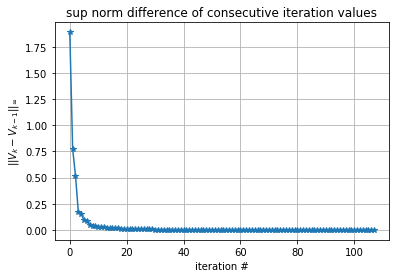

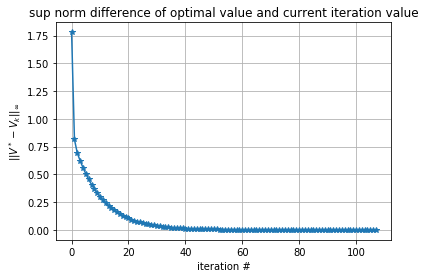

In [9]:
diff_1 = []
diff_2 = []
for k in range(1,V.shape[0]):
    diff_1.append(np.linalg.norm(V[k] - V[k-1],ord=np.inf))
    diff_2.append(np.linalg.norm(V[-1] - V[k-1],ord=np.inf))
    
plot_graph(range(len(diff_1)), diff_1, xlabel = "iteration #", ylabel = r"$||V_k - V_{k-1}||_\infty$", title = "sup norm difference of consecutive iteration values")
plot_graph(range(len(diff_2)), diff_2, xlabel = "iteration #", ylabel = r"$||V^* - V_k||_\infty$", title = "sup norm difference of optimal value and current iteration value")


In [10]:
policy, policy_value = policy_iteration(env)
# optimal_value = eval_policy(policy, np.random.normal(size=env.nS), env.P, n_iter = 100, gamma = 0.9)
# policy_value = np.vstack((policy_value,optimal_value))

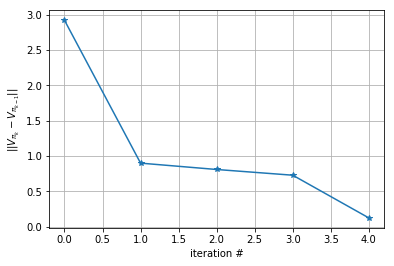

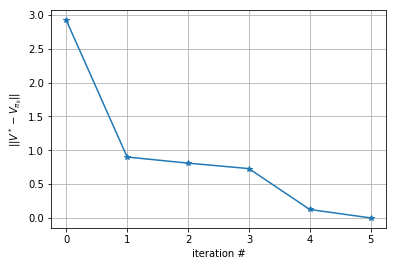

In [11]:
diff_3 = []
diff_4 = []
for k in range(1,policy_value.shape[0]):
    diff_3.append(np.linalg.norm(policy_value[k] - policy_value[k-1], ord=np.inf))
    
for k in range(0,policy_value.shape[0]):
    diff_4.append(np.linalg.norm(V[-1] - policy_value[k], ord=np.inf))

plot_graph(range(len(diff_3)), diff_3, xlabel = "iteration #", ylabel = r"$||V_{\pi_k} - V_{\pi_{k-1}}||$", title = "")
plot_graph(range(len(diff_4)), diff_4, xlabel = "iteration #", ylabel = r"$||V^* - V_{\pi_k}||$", title = "")

Optimal value grid plot

In [12]:
for i in range(policy_value.shape[1]//4):
    for j in range(4*i,4*(i+1)):
        print (np.round(policy_value[-1,j],2), end = "\t")
    print(end = "\n")

0.59	0.66	0.73	0.66	
0.66	0.0	0.81	0.0	
0.73	0.81	0.9	-0.0	
0.0	0.9	1.0	0.0	


Optimal policy grid plot

In [13]:
dict_action = {0:"Left",1:"Down",2:"Right",3:"Up"}

for i in range(env.nS//4):
    for j in range(4*i,4*(i+1)):
        print (dict_action[policy[j]], end = "\t")
    print(end = "\n")

Down	Right	Down	Left	
Down	Left	Down	Left	
Right	Down	Down	Left	
Left	Right	Right	Left	


Simulation of Movement

In [14]:
observation = env.reset()
for t in range(100):
    env.render()
    action = policy[observation]
    observation, reward, done, info = env.step(action)
    if done:
        env.render()
        print("Episode finished after {} timesteps".format(t+1))
        break


SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
Episode finished after 6 timesteps
